In [108]:
from pandas import DataFrame, read_csv, to_numeric
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from pickle import load, dump
from bigml.api import BigML
import kaggle
from pprint import pprint
from os import path

%matplotlib inline

In [109]:
big_ml_project = 'project/5d94a428eba31d460c00023f'
api = BigML(project=big_ml_project)

In [110]:
project = 'gmsc'
version = 'learning-curve'
jar_filename = project + '-' + version + '-picklejar'

In [111]:
def data_save(project_data):
    with open(jar_filename, 'wb') as file:
        dump(project_data,file)
def data_load():
    if path.exists(jar_filename):
        with open(jar_filename, 'rb') as file:
            project_data = load(file)
        return project_data
    return {}

In [112]:
project_data = data_load()

In [113]:
project_data['fulltrain file']='cs-train.csv'
project_data['test file']='cs-test.csv'

In [114]:
fulltrain=read_csv('./cs-training.csv',index_col=0)


In [115]:
fixed_seed=12345
train, valid = train_test_split(fulltrain, test_size=0.2, random_state=fixed_seed)
valid_filename = project + '-' + version + '-valid' + '.csv.bz2'
valid.to_csv(valid_filename,index_label='Id')
train_filename = project + '-' + version + '-train' + '.csv.bz2'
train.to_csv(train_filename,index_label='Id')
project_data['validation file'] = valid_filename
len(train)

120000

In [116]:
if 'models' not in project_data:
    project_data['models']={}
if 'train sources' not in project_data:
    project_data['train sources']={}
if 'train datasets' not in project_data:
    project_data['train datasets']={}

In [117]:
data_save(project_data)

In [118]:
if 'validation source' not in project_data:
    valid_src = api.create_source(valid_filename)
    api.ok(valid_src)
    project_data['validation source']=valid_src['resource']
else:
    valid_src = api.get_source(project_data['validation source'])
pprint(valid_src['resource'])

'source/5dc037487811dd7f2d0103f2'


In [119]:
if 'validation dataset' not in project_data:
    valid_ds = api.create_dataset(valid_src)
    api.ok(valid_ds)
    project_data['validation dataset']=valid_ds['resource']
else:
    valid_ds = api.get_dataset(project_data['validation dataset'])
pprint(valid_ds['resource'])

'dataset/5dc0374e7811dd05540010c3'


In [120]:
pprint(project_data)

{'fulltrain file': 'cs-train.csv',
 'models': {},
 'test file': 'cs-test.csv',
 'train datasets': {},
 'train sources': {},
 'validation dataset': 'dataset/5dc0374e7811dd05540010c3',
 'validation file': 'gmsc-learning-curve-valid.csv.bz2',
 'validation source': 'source/5dc037487811dd7f2d0103f2'}


In [121]:
#training_sizes=[500,2000,5000,10000,25000,50000,100000,150000]
training_sizes=[int(120000*i/10) for i in range(1,11) ]
models=['ensemble','deepnet']

In [124]:
for size in training_sizes:
    train_filename = project + '-' + version + '-train-' + str(size) + '.csv.bz2'
    if not path.exists(train_filename):
        #if size < 120000:
        #    print(size)
        train_partial = train.sample(size)
        #else:
        #    train_partial = train
        train_partial.to_csv(train_filename, index_label='Id')
        
    if size not in project_data['train sources']:
        train_src = api.create_source(train_filename)
        api.ok(train_src)
        project_data['train sources'][size]=train_src['resource']
    else:
        train_src = api.get_source(project_data['train sources'][size])
        
    if size not in project_data['train datasets']:
        train_ds = api.create_dataset(train_src)
        api.ok(train_ds)
        project_data['train datasets'][size]=train_ds['resource']
    else:
        train_ds = api.get_dataset(project_data['train datasets'][size])

In [125]:
data_save(project_data)

In [126]:
for size in training_sizes:
    for model_type in models:
        if size not in project_data['models']:
            project_data['models'][size]={}
        if model_type not in project_data['models'][size]:
            project_data['models'][size][model_type]={}
        model = project_data['models'][size][model_type]
        model['size'] = size
        model['model type'] = model_type
        model['train source'] = project_data['train sources'][size]
        model['train dataset'] = project_data['train datasets'][size]

In [127]:
model_args= {"objective_field": "SeriousDlqin2yrs"}
for size in project_data['models']:
    for model_type in project_data['models'][size]:
        print('Training ' + model_type + '-' + str(size))
        model_data = project_data['models'][size][model_type]
        train_ds = model_data['train dataset']
        if 'bigml model' not in model_data:
            if model_type == 'ensemble':
                model = api.create_ensemble(train_ds, model_args)
                api.ok(model)
                model_data['bigml model'] = model['resource']
            elif model_type == 'deepnet':
                model = api.create_deepnet(train_ds, model_args)
                api.ok(model)
                model_data['bigml model'] = model['resource']
        print('Done')

Training ensemble-12000
Done
Training deepnet-12000
Done
Training ensemble-24000
Done
Training deepnet-24000
Done
Training ensemble-36000
Done
Training deepnet-36000
Done
Training ensemble-48000
Done
Training deepnet-48000
Done
Training ensemble-60000
Done
Training deepnet-60000
Done
Training ensemble-72000
Done
Training deepnet-72000
Done
Training ensemble-84000
Done
Training deepnet-84000
Done
Training ensemble-96000
Done
Training deepnet-96000
Done
Training ensemble-108000
Done
Training deepnet-108000
Done
Training ensemble-120000
Done
Training deepnet-120000
Done


In [128]:
data_save(project_data)

In [129]:
for size in project_data['models']:
    for model_type in project_data['models'][size]:
        print('Evaluating ' + model_type + '-' + str(size))
        model_data = project_data['models'][size][model_type]
        if model_type == 'ensemble':
            model = api.get_ensemble(model_data['bigml model'])
        if model_type == 'deepnet':
            model = api.get_deepnet(model_data['bigml model'])
        if 'valid evaluation' not in model_data:
            evaluation = api.create_evaluation(model, project_data['validation dataset'])
            api.ok(evaluation)
            model_data['valid evaluation'] = evaluation['resource']
        if 'train evaluation' not in model_data:
            evaluation = api.create_evaluation(model, model_data['train dataset'])
            api.ok(evaluation)
            model_data['train evaluation'] = evaluation['resource']
        print('Done')

Evaluating ensemble-12000
Done
Evaluating deepnet-12000
Done
Evaluating ensemble-24000
Done
Evaluating deepnet-24000
Done
Evaluating ensemble-36000
Done
Evaluating deepnet-36000
Done
Evaluating ensemble-48000
Done
Evaluating deepnet-48000
Done
Evaluating ensemble-60000
Done
Evaluating deepnet-60000
Done
Evaluating ensemble-72000
Done
Evaluating deepnet-72000
Done
Evaluating ensemble-84000
Done
Evaluating deepnet-84000
Done
Evaluating ensemble-96000
Done
Evaluating deepnet-96000
Done
Evaluating ensemble-108000
Done
Evaluating deepnet-108000
Done
Evaluating ensemble-120000
Done
Evaluating deepnet-120000
Done


In [130]:
pprint(project_data)
data_save(project_data)

{'fulltrain file': 'cs-train.csv',
 'models': {12000: {'deepnet': {'bigml model': 'deepnet/5dc039e1e4768474680118ab',
                                'model type': 'deepnet',
                                'size': 12000,
                                'train dataset': 'dataset/5dc037787811dd05540010c6',
                                'train evaluation': 'evaluation/5dc04032e4768474680119f2',
                                'train source': 'source/5dc037737811dd7f2d0103fb',
                                'valid evaluation': 'evaluation/5dc04025e476847405000a12'},
                    'ensemble': {'bigml model': 'ensemble/5dc039d6e4768474680118a8',
                                 'model type': 'ensemble',
                                 'size': 12000,
                                 'train dataset': 'dataset/5dc037787811dd05540010c6',
                                 'train evaluation': 'evaluation/5dc040197811dd01370014c9',
                                 'train source': 'source/

In [131]:
deepnet_train_auc=[]
ensemble_train_auc=[]
deepnet_valid_auc=[]
ensemble_valid_auc=[]
for size in training_sizes:
    evaluation = api.get_evaluation(project_data['models'][size]['deepnet']['train evaluation'])
    auc = evaluation['object']['result']['model']['average_area_under_roc_curve']
    deepnet_train_auc.append(auc)
    
    evaluation = api.get_evaluation(project_data['models'][size]['ensemble']['train evaluation'])
    auc = evaluation['object']['result']['model']['average_area_under_roc_curve']
    ensemble_train_auc.append(auc)
    
    evaluation = api.get_evaluation(project_data['models'][size]['deepnet']['valid evaluation'])
    auc = evaluation['object']['result']['model']['average_area_under_roc_curve']
    deepnet_valid_auc.append(auc)
    
    evaluation = api.get_evaluation(project_data['models'][size]['ensemble']['valid evaluation'])
    auc = evaluation['object']['result']['model']['average_area_under_roc_curve']
    ensemble_valid_auc.append(auc)

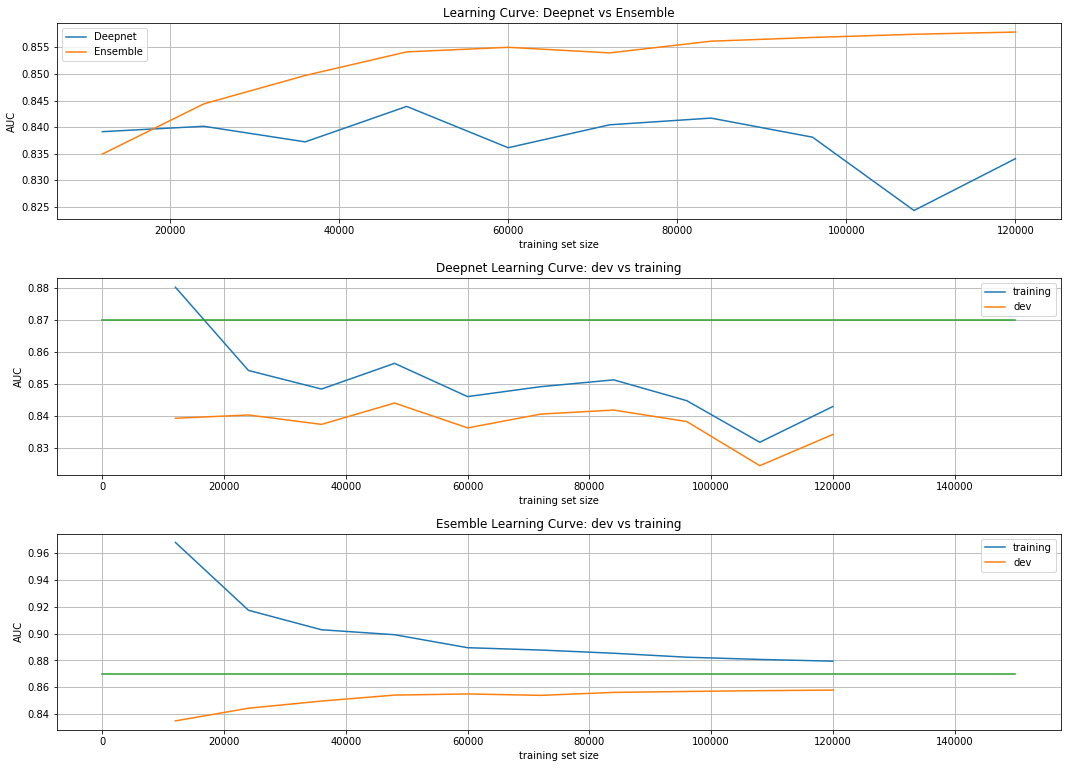

In [133]:
plt.subplots(3,1, figsize=(18, 13))
plt.subplots_adjust(hspace = 0.3)
plt.subplot(3,1,1)
plt.plot(training_sizes, deepnet_valid_auc, label="Deepnet")
plt.plot(training_sizes, ensemble_valid_auc, label="Ensemble")
plt.xlabel('training set size')
plt.ylabel('AUC')
plt.title('Learning Curve: Deepnet vs Ensemble')
plt.grid()
plt.legend()
plt.subplot(3,1,2)
plt.plot(training_sizes, deepnet_train_auc, label="training")
plt.plot(training_sizes, deepnet_valid_auc, label="dev")
plt.plot([0,150000],[0.87, 0.87])
plt.xlabel('training set size')
plt.ylabel('AUC')
plt.title('Deepnet Learning Curve: dev vs training')
plt.grid()
plt.legend()
plt.subplot(3,1,3)
plt.plot(training_sizes, ensemble_train_auc, label="training")
plt.plot(training_sizes, ensemble_valid_auc, label="dev")
plt.plot([0,150000],[0.87, 0.87])
plt.xlabel('training set size')
plt.ylabel('AUC')
plt.title('Esemble Learning Curve: dev vs training')
plt.grid()
plt.legend()
plt.show()

In [134]:
def delete_all(project_data):
    for size in project_data['models']:
        for model_type in project_data['models'][size]:
            model_data = project_data['models'][size][model_type]
            if model_type == 'ensemble':
                api.delete_ensemble(model_data['bigml model'])
            if model_type == 'deepnet':
                api.delete_deepnet(model_data['bigml model'])
            api.delete_evaluation(model_data['valid evaluation'])
            api.delete_evaluation(model_data['train evaluation'])     
    for size in project_data['train datasets']:
        api.delete_dataset(project_data['train datasets'][size])
    for size in project_data['train sources']:
        api.delete_source(project_data['train sources'][size])
    api.delete_dataset(project_data['validation dataset'])
    api.delete_source(project_data['validation source'])
    project_data={}
    data_save(project_data)

#delete_all(project_data)
